##**Experiment-8**

###**Aim: Apply Policy iteration algorithm to specific application**

<div style="text-align:center">
    <h1>Policy Iteration</h1>
</div>
<br>

<div style="text-align:center">
    <p>
        Policy Iteration is a fundamental algorithm used to solve Markov Decision Processes (MDPs).
        It aims to find the optimal policy that maximizes the expected cumulative reward for an agent interacting with an environment.
        This method alternates between two main steps: policy evaluation and policy improvement, and continues until convergence to the optimal policy.
    </p>
</div>
<br>

<div style="text-align:left">
    <h2>What is Policy Iteration?</h2>
    <p>
        Policy Iteration is a type of dynamic programming algorithm that solves an MDP by finding an optimal policy.
        It works by improving an initial policy through iterative evaluations and improvements, ensuring each iteration moves closer to the optimal solution.
        Unlike value iteration which updates the value function for each state, policy iteration updates the entire policy itself after evaluation.
    </p>
</div>
<br>

<div style="text-align:left">
    <h2>Steps Involved in Policy Iteration</h2>
    <p><b>1. Policy Evaluation:</b> Calculate the value function V(s) for a given policy &pi;. This is done either by solving a set of linear equations exactly or through iterative approximation.</p>
    <p><b>2. Policy Improvement:</b> Update the policy by selecting the action that yields the highest expected return using the current value function.</p>
    <p><b>3. Convergence Check:</b> Check if the policy is stable. If it is not, repeat the evaluation and improvement steps. If stable, the optimal policy has been found.</p>
</div>
<br>

<div style="text-align:left">
    <h2>Mathematical Formulation</h2>
    <p>
        Given a policy &pi;, the value function V<sup>&pi;</sup>(s) satisfies:
    </p>
    <p style="margin-left: 30px;">
        V<sup>&pi;</sup>(s) = R(s, &pi;(s)) + &gamma; &sum;<sub>s'</sub> P(s' | s, &pi;(s)) V<sup>&pi;</sup>(s')
    </p>
    <p>where:</p>
    <ul>
        <li><b>R(s, a)</b> is the expected immediate reward after taking action a in state s.</li>
        <li><b>&gamma;</b> is the discount factor (0 ≤ &gamma; ≤ 1), controlling the importance of future rewards.</li>
        <li><b>P(s' | s, a)</b> is the probability of reaching state s' from state s by taking action a.</li>
    </ul>
</div>
<br>

<div style="text-align:left">
    <h2>Advantages of Policy Iteration</h2>
    <ul>
        <li>Guaranteed to converge to the optimal policy for finite MDPs.</li>
        <li>Each iteration typically improves the policy significantly.</li>
        <li>More stable and faster in certain cases compared to value iteration.</li>
        <li>Easy to implement and analyze theoretically.</li>
    </ul>
</div>
<br>

<div style="text-align:left">
    <h2>Disadvantages of Policy Iteration</h2>
    <ul>
        <li>Policy evaluation can be computationally expensive for large state spaces.</li>
        <li>Memory consumption may be high if the number of states is very large.</li>
        <li>For continuous or very large MDPs, approximate methods may be needed.</li>
    </ul>
</div>
<br>

<div style="text-align:left">
    <h2>Applications of Policy Iteration</h2>
    <ul>
        <li>Robotics: For path planning and navigation in dynamic environments.</li>
        <li>Game AI: To create agents that can find optimal strategies in games.</li>
        <li>Finance: In portfolio optimization and decision-making under uncertainty.</li>
        <li>Healthcare: To optimize treatment strategies over time for patients.</li>
    </ul>
</div>
<br>

<div style="text-align:left">
    <h2>Conclusion</h2>
    <p>
        Policy Iteration provides a powerful method for solving MDPs by alternating between policy evaluation and policy improvement.
        Although it may be computationally intensive for very large problems, its ability to reliably find an optimal policy makes it a cornerstone technique in reinforcement learning and dynamic programming.
    </p>
</div>


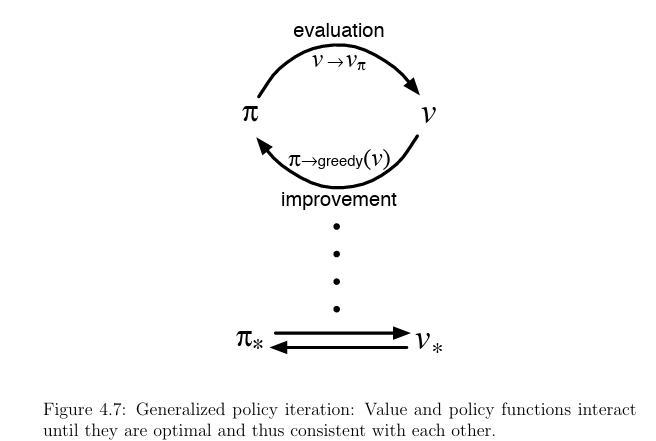

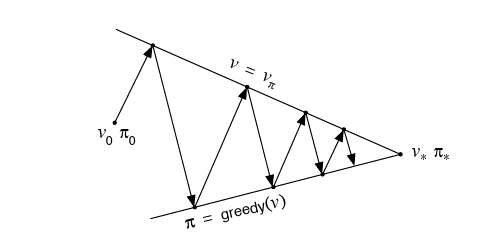

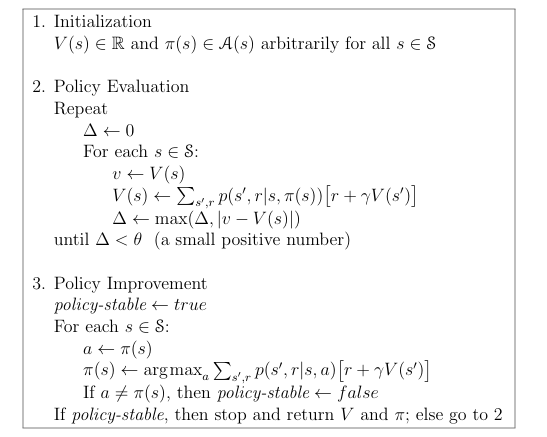

In [ ]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()


def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(environment, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)



## Import the necessary software libraries:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Initialize the environment

In [ ]:
env = Maze()

In [ ]:
env.reset()

(0, 0)

In [ ]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.imshow(frame)

In [ ]:
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space shape: [5 5]
Number of actions: 4


## Define the policy $\pi(\cdot|s)$

#### Create the policy $\pi(\cdot|s)$

In [ ]:
policy_probs = np.full((5, 5, 4), 0.25)

In [ ]:
policy_probs

array([[[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]]])

In [ ]:
def policy(state):
    return policy_probs[state]

#### Test the policy with state (0, 0)

In [ ]:
action_probabilities = policy((0,0))
for action, prob in zip(range(4), action_probabilities):
    print(f"Probability of taking action {action}: {prob}")

Probability of taking action 0: 0.25
Probability of taking action 1: 0.25
Probability of taking action 2: 0.25
Probability of taking action 3: 0.25


#### See how the random policy does in the maze

In [ ]:
test_agent(env, policy, episodes=1)

#### Plot the policy

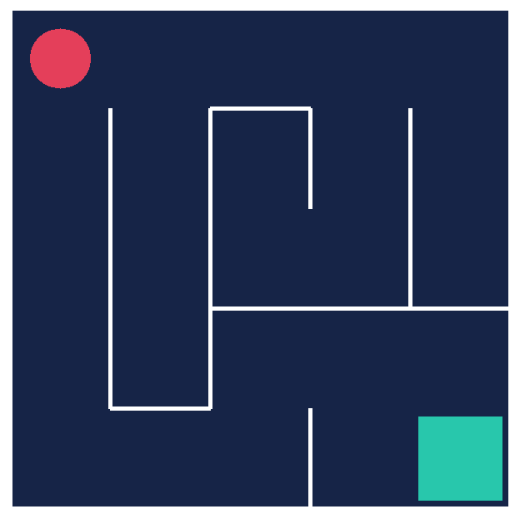

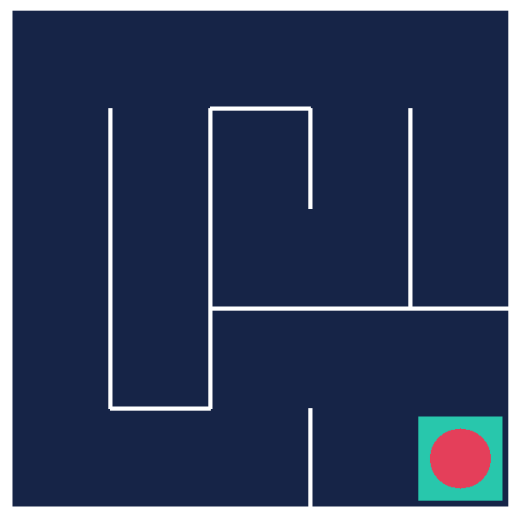

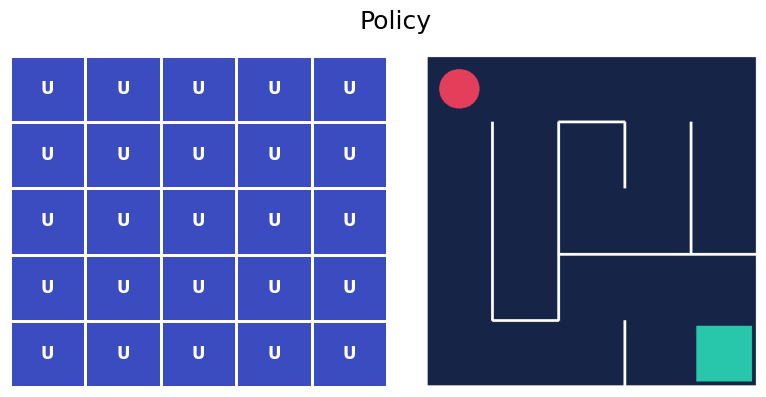

In [ ]:
plot_policy(policy_probs, frame)

## Define value table $V(s)$

#### Create the $V(s)$ table

In [ ]:
state_values = np.zeros(shape=(5,5))

In [ ]:
state_values

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

#### Plot $V(s)$

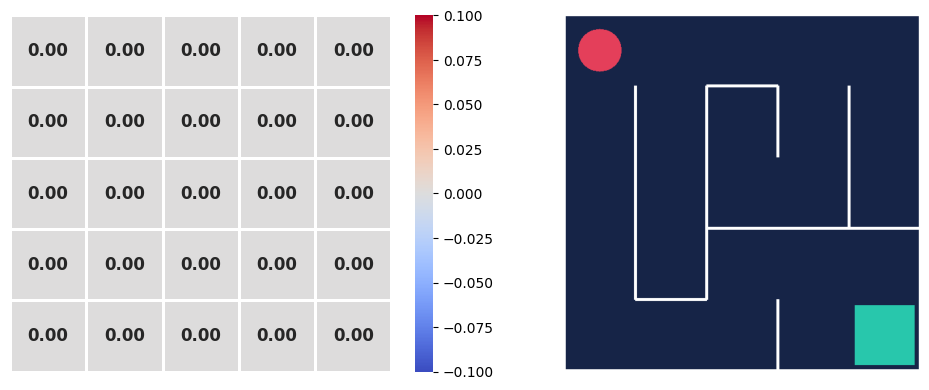

In [ ]:
plot_values(state_values, frame)

## Implement the Policy Iteration algorithm

In [ ]:
# Function to evaluate a given policy by computing the state-value function

def policy_evaluation(policy_probs, state_values, theta=1e-6, gamma=0.99):

    delta = float("inf")              # Start with a large delta to enter the loop

    while delta > theta:              # Loop until values converge (change less than theta)
        delta = 0                     # Reset delta for this iteration

        for row in range(5):          # Iterate through each row in the grid
            for col in range(5):      # Iterate through each column
                old_value = state_values[(row, col)]  # Store current value of the state
                new_value = 0         # Initialize new value
                action_probabilities = policy_probs[(row, col)]                      # Get current policy's action probs

                for action, prob in enumerate(action_probabilities):                 # For each action in policy
                    next_state, reward, _, _ = env.simulate_step((row, col), action) # Simulate result
                    new_value += prob * (reward + gamma * state_values[next_state])  # Bellman update

                state_values[(row, col)] = new_value            # Update the value function
                delta = max(delta, abs(old_value - new_value))  # Track maximum change

In [ ]:
# Function to improve the policy based on current value function
def policy_improvement(policy_probs, state_values, gamma=0.99):
    policy_stable = True  # Assume policy is stable initially

    for row in range(5):
        for col in range(5):
            old_action = policy_probs[(row, col)].argmax()  # Current best action
            new_action = None                               # To store new best action
            max_qsa = float("-inf")                         # Initialize to lowest possible Q-value

            for action in range(4):                                               # Check all 4 possible actions
                next_state, reward, _, _ = env.simulate_step((row, col), action)  # Simulate step
                qsa = reward + gamma * state_values[next_state]                   # Compute Q-value

                if qsa > max_qsa:                   # If better than current best
                    max_qsa = qsa                   # Update best Q-value
                    new_action = action             # Update best action

            action_probs = np.zeros(4)              # Reset action probabilities
            action_probs[new_action] = 1.0          # Make the best action deterministic
            policy_probs[(row, col)] = action_probs # Update policy

            if new_action != old_action:  # Check if policy changed
                policy_stable = False     # If changed, policy is not yet stable
    return policy_stable                  # Return whether policy has stabilized

In [ ]:
# Main function to perform policy iteration (alternate eval & improvement)
def policy_iteration(policy_probs, state_values, theta=1e-6, gamma=0.99):
    policy_stable = False                     # Start with unstable policy

    while not policy_stable:        # Repeat until policy stops changing
        policy_evaluation(policy_probs, state_values, theta, gamma)  # Evaluate policy
        policy_stable = policy_improvement(policy_probs, state_values, gamma) # Improve it


In [ ]:
# Call policy iteration to find optimal policy and values
policy_iteration(policy_probs, state_values)

In [ ]:
policy_probs

array([[[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]],

       [[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]]])

In [ ]:
state_values

array([[-9.56189012e+00, -1.04662712e+01, -1.13616085e+01,
        -1.22479924e+01, -1.31255125e+01],
       [-8.64837287e+00, -1.13616085e+01, -1.57057735e+01,
        -1.31255125e+01, -1.39942574e+01],
       [-7.72562818e+00, -1.22479924e+01, -1.48543157e+01,
        -1.39942574e+01, -1.48543148e+01],
       [-6.79356283e+00, -1.31255125e+01, -2.97019861e+00,
        -1.99009861e+00, -1.00009861e+00],
       [-5.85208268e+00, -4.90109263e+00, -3.94049662e+00,
        -1.00009861e+00, -9.86059949e-05]])

## Show results

Show resulting value table V(s)

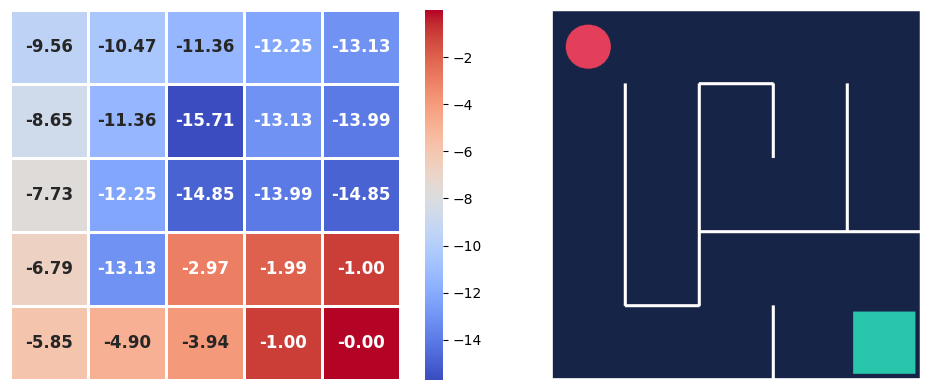

In [ ]:
plot_values(state_values, frame)

Show resulting policy $\pi(\cdot|s)$

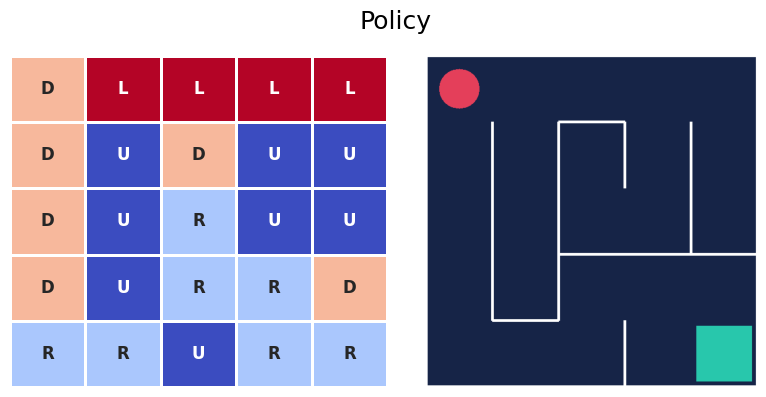

In [ ]:
plot_policy(policy_probs, frame)

#### Test the resulting agent

In [ ]:
test_agent(env, policy)

<div style="text-align:left">
    <h2>Conclusion</h2>
    <p>
        Policy Iteration is a powerful and systematic method to find the optimal policy in a Markov Decision Process.
        By alternating between evaluating the current policy and improving it based on the value function, the algorithm guarantees convergence to the best possible strategy for an agent.
        Although it can be computationally heavy for very large state spaces, it is highly effective for smaller or well-structured problems.
        Policy Iteration forms the foundation for many advanced reinforcement learning methods and continues to be widely applied in fields like robotics, game AI, and operations research.
    </p>
</div>
